## A trip down memory lane - with some graphs

In [1]:
import pandas as pd
import collections
import json
import numpy as np
import random
import operator
import networkx as nx
from matplotlib.ticker import PercentFormatter

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
def randomize_colors(length):
    """ Create an array of random colors of given length """

    return ['#' + ''.join(map(lambda x: random.choice('0123456789abcde'), range(6))) for i in range(length)]

In [4]:
def plot_emails_years(filename='global_stats_year.json'):
    """ Plot emails data over years as a bar chart """

    data = json.load(open(filename))
    years = list(data.keys())
    emails = list(data.values())

    
    plt.bar(years, emails, align='center', alpha=0.8, edgecolor='000',
            color=randomize_colors(len(years)))
    plt.xticks(np.arange(len(years)), rotation='45')
    plt.grid(True)
    plt.ylabel('Email')
    plt.xlabel('Year')
    plt.title('Year-wise Emails')
    plt.show()
    print(data)
    print('Total emails =>',sum(emails))

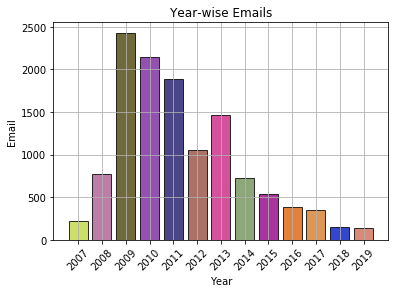

{'2007': 217, '2008': 772, '2009': 2430, '2010': 2140, '2011': 1883, '2012': 1050, '2013': 1463, '2014': 722, '2015': 542, '2016': 389, '2017': 349, '2018': 155, '2019': 134}
Total emails => 12246


In [5]:
plot_emails_years()

## BangPypers Box-Office - Top of the charts

In [6]:
def plot_top_posters_pie(filename='global_stats_sender.json', count=10, show_all=False):
    """ Plot top posters as a pie chart """

    data = json.load(open(filename))
    counter = collections.Counter(data)
    total_emails = sum(counter.values())
    total_posters = len(counter)
    print("Total emails =>",total_emails)
    print("Total posters =>", total_posters)
    top = counter.most_common(count)
    # print('Top email stats', top)

    labels = [x[0] for x in top]
    nums  = [x[1] for x in top]

    total_nums = sum(nums)
    total_rest = total_emails - total_nums
    print('Total at top =>',total_nums)
    perc = round(100.0*total_nums//total_emails, 2)
    print("Percentage of top {} posters of all emails => {}".format(count, perc))
          
    if show_all:
        nums.append(total_rest)
        labels.append('Others')
    
    figureObject, axesObject = plt.subplots()
    axesObject.pie(nums, labels=labels,autopct='%1.2f',startangle=90, labeldistance=1.02,shadow=True, 
                   counterclock=True)
    axesObject.axis('equal')

    plt.show()

Using matplotlib backend: TkAgg
Total emails => 12246
Total posters => 1149
Total at top => 3618
Percentage of top 10 posters of all emails => 29.0


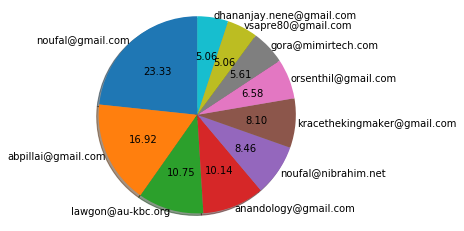

In [7]:
# Network effect ? Well not really!
# Top 10 posters make up close to 30% of all emails...

%matplotlib 
plot_top_posters_pie(count=10)

## So what are the rest of the members doing ?

In [8]:
def plot_post_frequency(filename='global_stats_sender.json'):
    """ Plot most common frequencies of posting as a histogram """

    data = json.load(open(filename))
    counts = []
    count_dict = collections.defaultdict(int)
    
    for v in data.values():
        counts.append(v)
        
    vals = {i:x for i,x in enumerate(sorted(counts))}
    # print(vals)
    series = pd.Series(vals)
    # print(counts)
    # series.plot.hist(bins=1000, density=True, facecolor='g')
    plt.hist(counts, bins=1000, density=True, facecolor='r')
    plt.xlabel('Count')
    plt.xlim(-10, 100)
    plt.grid(True)
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.ylabel('Percentage')
    plt.show()

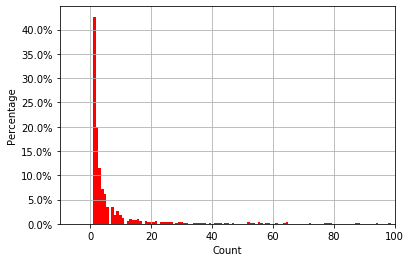

In [9]:
plot_post_frequency()

#### 45% of the people have posted just one email to the group :-)

## Visualizing the Network

In [10]:
def plot_thread_network(filename='global_thread_graph.json', year=2009, month=None):
    """ Plot email threads and participants as a network graph """

    data = json.load(open(filename))

    G = nx.Graph()
    nodes = {}
    edges = []
    
    # A dense core with lots of edges indicate a very active year
    for key in data.keys():
        if key.startswith(str(year) + '/'):
            if month != None and key.find('/' + month + '/') == -1: continue 
            # Each participant is a node.
            participants = data[key]
            if len(participants) == 0: continue
            
            for person in participants:
                if person not in nodes:
                    # Add a node
                    G.add_node(person)
                    nodes[person] = 1

            # First sender is the thread creator
            # Add edge from him to all else
            # in the thread
            sender = participants[0]
            for person in participants[1:]:
                # Dont add edge to same node
                if person != sender:
                    edge = (sender, person)
                    G.add_edge(*edge)

    # Graph is ready now
    plt.subplots()
    options = {'node_color': 'black',
               'node_size': 50,
               'width': 1}
    
    nx.draw(G, with_labels=False, font_weight='normal', **options)

In [11]:
%matplotlib
plot_thread_network(year=2019)
# Very tight network - many interactions!

Using matplotlib backend: TkAgg


In [12]:
# Core network is a bit less dense
plot_thread_network(year=2019)

## The Hot Topics

In [13]:
def plot_emails_year(filename='global_stats_month.json', year=2009):
    """ Plot month-wise emails data for a given year """
    
    data = json.load(open(filename))

    months = []
    values = []

    for key in data.keys():
        if key.startswith(str(year)):
            months.append(key)
            values.append(data[key])

    plt.bar(months, values, align='center', alpha=0.8, edgecolor='000',
            color=randomize_colors(len(months)))
    plt.xticks(np.arange(len(months)), rotation='45')
    plt.ylabel('Email')
    plt.xlabel('Month')
    plt.grid(True)
    plt.title('Month-wise Emails (Year: {})'.format(year))

    plt.show()

In [14]:
plot_emails_year()
# Why the sudden explosion in Oct 2009 ?

### Untangling the Threads...

In [15]:
def plot_emails_threads(filename='global_thread_stats.json', cutoff=10):
    """ Plot year vs # threads with emai count >= cutoff in the entire year """
    
    data = json.load(open(filename))

    years = []
    values = []

    for year in range(2007, 2020):
        year_total = 0
        years.append(str(year))
        
        for key in data.keys():
            if key.startswith(str(year)):
                val = data[key]
                if val >= cutoff:
                    year_total += 1
                
        values.append(year_total)

    print(dict(zip(years,values)))
    plt.bar(years, values, align='center', alpha=0.8, edgecolor='000',
            color=randomize_colors(len(years)))
    plt.xticks(np.arange(len(years)), rotation='45')
    plt.ylabel('Large Threads (>=10)')
    plt.xlabel('Year')
    plt.grid(True)
    plt.title('Year-wise top threads')

    plt.show()

In [16]:
plot_emails_threads(cutoff=10)

{'2007': 4, '2008': 12, '2009': 56, '2010': 49, '2011': 45, '2012': 21, '2013': 33, '2014': 9, '2015': 8, '2016': 1, '2017': 3, '2018': 0, '2019': 0}


### What made people talk about stuff and debate ?

In [17]:
import hashlib
import os

def load_email(message_id):
    """ Given message ID, load the email """
    
    yr, month, msg_id = message_id.split('/')
    msg_idh = hashlib.md5(msg_id.encode('utf-8')).hexdigest()
    filename = os.path.join('archives', str(yr), month, msg_idh + '.eml')
    print('Loading email from {}\n'.format(filename))
    print('------------------------')
    print(open(filename).read())

In [18]:
import collections
import pprint

def top_email_threads(n=10, year=None):
    """ Find top email threads """
    
    data = json.load(open('global_thread_stats.json'))
    if year == None:
        pprint.pprint(collections.Counter(data).most_common(n), indent=4)
    else:
        year_data = {}
        
        for key in data.keys():
            if key.startswith(str(year)):
                year_data[key] = data[key]

        pprint.pprint(collections.Counter(year_data).most_common(n), indent=4)  

## 2008

In [19]:
top_email_threads(year=2008)

[   (   '2008/January/6e38f9f00801052259m321f9fafi1e0a2bdb1382b941@mail.gmail.com',
        31),
    (   '2008/January/8548c5f30801030517u497474a2kf22914df05a3f3bd@mail.gmail.com',
        23),
    ('2008/May/mailman.63.1209463219.1430.bangpypers@python.org', 21),
    ('2008/April/200804031731.13257.kushaldas@gmail.com', 17),
    (   '2008/July/a13a3b480807240510y5f8975efoa822996077647ea1@mail.gmail.com',
        15),
    (   '2008/August/8548c5f30808010642l7284c4ddp4b9e129ed2572d42@mail.gmail.com',
        15),
    ('2008/September/004a01c9122e$be064f90$5fc513ac@pwit.com', 15),
    (   '2008/March/23EECEC9B06584478B1C9E38C253D35FF230FF@minsk.us.stoke.com',
        14),
    ('2008/February/001701c87513$6bbdfa20$0701a8c0@Ganesh', 12),
    (   '2008/June/ff0964720806161258k733e70b8m1459a1a919ef0599@mail.gmail.com',
        11)]


In [20]:
# First email on a "Django" meetup!
load_email('2008/January/6e38f9f00801052259m321f9fafi1e0a2bdb1382b941@mail.gmail.com')

Loading email from archives/2008/January/52b2a27110d5a4982f529ffdbe374fe9.eml

------------------------
From ramdas at developeriq.com  Sun Jan  6 07:59:19 2008
From: ramdas at developeriq.com (Ramdas S)
Date: Sun, 6 Jan 2008 12:29:19 +0530
Subject: [BangPypers] Anyone interested in a specific Django meet
In-Reply-To: <2D210F2C-898D-4849-B6AC-B7A3099B0CCC@btbytes.com>
References: <6e38f9f00801050708k2cf27c79re7aaa8dc807f9aab@mail.gmail.com>
	<586572.16098.qm@web52112.mail.re2.yahoo.com>
	<1c4dc2780801051058p94e7e45j73c4a014b6e3b016@mail.gmail.com>
	<477FFACB.20102@gmail.com>
	<2D210F2C-898D-4849-B6AC-B7A3099B0CCC@btbytes.com>
Message-ID: <6e38f9f00801052259m321f9fafi1e0a2bdb1382b941@mail.gmail.com>

Great!

What abt last saturday of the month? I am comfortable with Thoughtworks

I agree while newbies are welcome, the discussions need to be beyond writing
a blog/wiki/to-do stuff in Django.

I consider Django as the big hope for a mass based Python web development
platform, like RAILS/LA

## 2009 

In [21]:
top_email_threads(year=2009)

[   (   '2009/May/9963e56e0905180836y6eceea60tb9d049594000f5b4@mail.gmail.com',
        54),
    ('2009/November/mailman.831.1257919869.2872.bangpypers@python.org', 52),
    (   '2009/June/7c73a13a0906112131r72e6887i8f4c29e54e7dad95@mail.gmail.com',
        46),
    (   '2009/October/ad668e4f0910050543q29cd6347q3891d0faef6a8276@mail.gmail.com',
        43),
    (   '2009/October/6a438da70910120139k4aea3dfev34bda97a345b7883@mail.gmail.com',
        42),
    (   '2009/October/8548c5f30910142312y4c24c1few3b70386fe04be8c8@mail.gmail.com',
        40),
    (   '2009/October/4EF2BF691B890546B2694C99A2852F0C01BB8C86@astserver3.akebonosoft.com',
        40),
    (   '2009/February/8548c5f30902270235h7ca83c0ay995baae722b8d174@mail.gmail.com',
        32),
    (   '2009/May/def7ddf20904280408u26702874p1046bc6216336cbc@mail.gmail.com',
        32),
    (   '2009/December/a13a3b480912220540t4723facan164fbef38f0583fe@mail.gmail.com',
        32)]


In [22]:
# "Python Logo"
load_email('2009/May/9963e56e0905180836y6eceea60tb9d049594000f5b4@mail.gmail.com')

Loading email from archives/2009/May/a76be8acc92a71db651e7cfbf2c1316a.eml

------------------------
From noufal at gmail.com  Mon May 18 17:36:07 2009
From: noufal at gmail.com (Noufal Ibrahim)
Date: Mon, 18 May 2009 21:06:07 +0530
Subject: [BangPypers] PyCon India logo contest!
Message-ID: <9963e56e0905180836y6eceea60tb9d049594000f5b4@mail.gmail.com>

Hello everyone,
  One of the things that came up in yesterday's meeting (whose minutes
I will post shortly) is that we need a 'logo' for PyCon India. A few
of us had ideas but artistic talent was in short supply.

  If there are any people out there that are talented in digital art,
it would be really cool if you could volunteer to make a logo for the
event. You get exclusive bragging rights. The logo after all sort of
defines the mood and style of the event. It's also cool if you can get
a logo designed by friend who's artistically clued in. We're not
paying for this and like the rest of the effort want it to be
something that springs f

In [23]:
# Just Fucking google it
load_email('2009/June/7c73a13a0906112131r72e6887i8f4c29e54e7dad95@mail.gmail.com')

Loading email from archives/2009/June/12ae46f1d679f060beb41344fb623f67.eml

------------------------
From sridhar.ratna at gmail.com  Fri Jun 12 06:31:24 2009
From: sridhar.ratna at gmail.com (Sridhar Ratnakumar)
Date: Thu, 11 Jun 2009 21:31:24 -0700
Subject: [BangPypers] Responding to people who lack the curiosity
Message-ID: <7c73a13a0906112131r72e6887i8f4c29e54e7dad95@mail.gmail.com>

On Thu, Jun 4, 2009 at 3:22 AM, Srijayanth Sridhar<srijayanth at gmail.com> wrote:
> Hello,
>
> My name is Jayanth. I am new to BangPypers and Python in general. I have
> been working on Ruby however so I am not lost or anything.
>
> I wanted to point out that on ruby-lang several posters from India seem to
> have no concept of how to phrase questions. They also lack the basic
> curiosity to try common things before they go asking around for answers.
> I've pondered for a long time why this phenomenon is particularly large here
> whereas nearly everywhere else, even in countries where English is a
> no

In [24]:
# Email on Scipy India
load_email('2009/October/ad668e4f0910050543q29cd6347q3891d0faef6a8276@mail.gmail.com')

Loading email from archives/2009/October/6291de1618e0796f98620fb844a2bc7d.eml

------------------------
From kadambari.devarajan at gmail.com  Mon Oct  5 14:43:09 2009
From: kadambari.devarajan at gmail.com (Kadambari Devarajan)
Date: Mon, 5 Oct 2009 18:13:09 +0530
Subject: [BangPypers] [ANN][X-Post] SciPy India conference in Dec. 2009
Message-ID: <ad668e4f0910050543q29cd6347q3891d0faef6a8276@mail.gmail.com>

Greetings,

The first "Scientific Computing with Python" conference in India (
http://scipy.in) will be held from December 12th to 17th, 2009 at the
Technopark in Trivandrum, Kerala, India (http://www.technopark.org/).

The theme of the conference will be "Scientific Python in Action" with
respect to application and teaching.  We are pleased to have Travis
Oliphant, the creator and lead developer of numpy (http://numpy.scipy.org)
as the keynote speaker.

Here is a rough schedule of the conference:

   Sat.    Dec. 12  (conference)
   Sun.    Dec. 13  (conference)
   Mon.   Dec. 14